In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(16, 6)})

In [395]:
df = pd.read_csv('2_taxi_nyc.csv', sep=',')

In [396]:
df.head()

,pickup_dt,pickup_month,borough,pickups,hday,spd,vsb,temp,dewp,slp,pcp 01,pcp 06,pcp 24,sd
0,2015-01-01 01:00:00,Jan,Bronx,152,Y,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00,Jan,Brooklyn,1519,Y,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0
2,2015-01-01 01:00:00,Jan,EWR,0,Y,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0
3,2015-01-01 01:00:00,Jan,Manhattan,5258,Y,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0
4,2015-01-01 01:00:00,Jan,Queens,405,Y,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0


In [397]:
# Посмотрим какие районы представлены в данных
q_bor = """SELECT 
                DISTINCT(borough)
           FROM df
       """

In [398]:
sqldf(q_bor)

,borough
0,Bronx
1,Brooklyn
2,EWR
3,Manhattan
4,Queens
5,Staten Island
6,None


In [401]:
# Посмотрим на описательные статистики колонки pickups
q_stat = """WITH df_stat AS (SELECT pickups, 
                                    ROW_NUMBER() OVER (ORDER BY pickups) AS row_num,
                                    COUNT(*) OVER() AS total_rows
                             FROM df)
            SELECT ROUND(AVG(pickups), 0) as avg_pickups, 
                   COUNT(pickups) as num_pickups, 
                   MIN(pickups) as min_pickups, 
                   MAX(pickups) as max_pickups, 
                   SUM(pickups) as total_pickups,
                   (SELECT AVG(pickups)
                    FROM df_stat
                   WHERE row_num IN  
                                 (CASE WHEN total_rows % 2 = 0 THEN total_rows / 2 ELSE (total_rows / 2.0) + 0.5 END,
                                 ((total_rows / 2.0) - 0.5))) AS median_pickups,
                   (SELECT AVG(pickups)
                    FROM df_stat
                   WHERE row_num IN  
                                 (CASE WHEN total_rows % 4 = 0 THEN total_rows / 4 ELSE (total_rows / 4.0) + 0.75 END,
                                 ((total_rows / 4.0) - 0.25))) AS percentile_25,
                   (SELECT AVG(pickups)
                    FROM df_stat
                   WHERE row_num IN  
                                 (CASE WHEN total_rows % 4 = 0 THEN ((total_rows * 3.0) / 4.0) ELSE ((total_rows * 3.0) / 4.0) + 0.25 END,
                                 (((total_rows *3.0)/ 4.0) - 0.75))) AS percentile_75              
                   
          FROM df                                             
       """

In [402]:
sqldf(q_stat)

,avg_pickups,num_pickups,min_pickups,max_pickups,total_pickups,median_pickups,percentile_25,percentile_75
0,490.0,29101,0,7883,14265773,54.0,1.0,449.0


In [177]:
# Температура в данных представлена в градусах Фаренгейта. Переведём данные в градусы Цельсия.
# Также посмотрим на минимальную температуру по имеющимся данным.
q_cels_min = """SELECT borough,
                       MIN(temp_cels) AS min_temp
                FROM
                   (SELECT borough,
                           ROUND(((temp - 32) * 5 / 9), 0) AS temp_cels
                    FROM df)
              """

In [178]:
sqldf(q_cels_min)

,borough,min_temp
0,Bronx,-17.0


In [179]:
# Максимальная температура
q_cels_max = """SELECT borough,
                       MAX(temp_cels) AS min_temp
               FROM
                   (SELECT borough,
                           ROUND(((temp - 32) * 5 / 9), 0) AS temp_cels
                   FROM df)
             """

In [180]:
sqldf(q_cels_max)

,borough,min_temp
0,Bronx,32.0


In [181]:
# Посмотрим в какой день было максимальное количество поездок
q_pick_max = """SELECT pickup_dt,
                       MAX(pickups) AS max_pick
                FROM df
             """

In [182]:
sqldf(q_pick_max)

,pickup_dt,max_pick
0,2015-06-27 22:00:00,7883


In [183]:
# Посмотрим в какой день было минимальное количество поездок
q_pick_min = """SELECT pickup_dt,
                       MIN(pickups) AS min_pick
                FROM df
             """

In [184]:
sqldf(q_pick_min)

,pickup_dt,min_pick
0,2015-01-01 01:00:00,0


In [185]:
# Посмотрим на среднее количество поездок по районам
q_avg = """SELECT borough,
                  AVG(pickups) as avg_pickups
           FROM df
           GROUP BY borough
           ORDER BY avg_pickups DESC
       """

In [186]:
sqldf(q_avg)

,borough,avg_pickups
0,Manhattan,2387.253281
1,Brooklyn,534.431269
2,Queens,309.354824
3,Bronx,50.667050
4,None,2.057180
5,Staten Island,1.601888
6,EWR,0.024177


In [347]:
# Выведем количество поездок по районам и процент об общего количества поездок
q_total = """SELECT borough,
                    pickups_total,
                    (pickups_total * 100 / (SELECT SUM(pickups) FROM df)) AS pickups_percent
             FROM 
                 (SELECT borough,
                         SUM(pickups) as pickups_total
                 FROM df
                 GROUP BY borough
                 ORDER BY pickups_total DESC)
           """

In [348]:
sqldf(q_total)

,borough,pickups_total,pickups_percent
0,Manhattan,10367841,72
1,Brooklyn,2321035,16
2,Queens,1343528,9
3,Bronx,220047,1
4,Staten Island,6957,0
5,None,6260,0
6,EWR,105,0


In [189]:
# Посмотрим на месяцы, в которые совершено больше всего поездок
q_month = """SELECT pickup_month,
                    SUM(pickups) as pickups_total
             FROM df
             GROUP BY pickup_month
             ORDER BY pickups_total DESC
          """

In [190]:
sqldf(q_month)

,pickup_month,pickups_total
0,Jun,2816348
1,May,2696638
2,Apr,2279842
3,Feb,2263427
4,Mar,2261710
5,Jan,1947808


In [191]:
# Выведем записи, где количество поездок больше среднего
q_more_avg = """SELECT *
                FROM df
                WHERE pickups >
                     (SELECT AVG(pickups) as avg_pickups
                      FROM df)
                ORDER BY pickups DESC
                LIMIT 10
             """

In [192]:
sqldf(q_more_avg)

,pickup_dt,pickup_month,borough,pickups,hday,spd,vsb,temp,dewp,slp,pcp 01,pcp 06,pcp 24,sd
0,2015-06-27 22:00:00,Jun,Manhattan,7883,N,8.00,5.500000,60.00,56.500000,1016.9,0.065000,0.00,0.00,0.0
1,2015-06-27 21:00:00,Jun,Manhattan,7801,N,8.00,3.500000,61.50,56.000000,1017.0,0.045000,0.00,0.00,0.0
2,2015-06-27 23:00:00,Jun,Manhattan,7711,N,10.25,3.200000,60.75,57.250000,1015.7,0.076667,0.01,0.00,0.0
3,2015-06-27 20:00:00,Jun,Manhattan,7512,N,9.00,8.000000,65.00,55.000000,1018.2,0.010000,0.00,0.25,0.0
4,2015-05-16 23:00:00,May,Manhattan,7271,N,0.00,9.100000,71.00,60.000000,1019.2,0.000000,0.00,0.00,0.0
5,2015-05-16 22:00:00,May,Manhattan,7240,N,3.00,9.100000,72.00,61.000000,1018.8,0.000000,0.00,0.00,0.0
6,2015-06-28 00:00:00,Jun,Manhattan,7140,N,10.00,2.666667,60.00,56.666667,1015.5,0.150000,0.39,0.00,0.0
7,2015-06-27 19:00:00,Jun,Manhattan,7114,N,7.00,10.000000,69.00,53.000000,1018.8,0.000000,0.00,0.26,0.0
8,2015-06-23 19:00:00,Jun,Manhattan,7046,N,8.00,8.000000,87.00,72.000000,1008.9,0.000000,0.00,0.00,0.0
9,2015-05-16 21:00:00,May,Manhattan,6976,N,0.00,8.000000,73.00,60.000000,1019.1,0.000000,0.00,0.00,0.0


In [193]:
# Посмотрим на количество поездок по районам в выходные и празничные дни
q_hday = """SELECT borough,
                   SUM(pickups) AS pickups_hday
            FROM df
            WHERE hday == 'Y'
            GROUP BY borough
            ORDER BY pickups_hday DESC
         """

In [194]:
sqldf(q_hday)

,borough,pickups_hday
0,Manhattan,340000
1,Brooklyn,88011
2,Queens,53562
3,Bronx,8027
4,Staten Island,250
5,None,244
6,EWR,7


In [446]:
# Посмотрим районы, где среднее количество поездок в выходные и праздничные дни больше, чем в рабочие дни
q_hday1 = """SELECT borough
             FROM
             (SELECT df.borough, 
                    AVG(no_hday.pickups) AS pickups_no_hday_avg,
                    AVG(df.pickups) AS pickups_avg, 
                    AVG(hday.pickups) AS pickups_hday_avg
             FROM df 
             LEFT JOIN (SELECT borough, 
                        AVG(pickups) AS pickups
                  FROM df 
                  WHERE hday = 'Y' 
                  GROUP BY borough) AS hday 
             ON df.borough = hday.borough
             LEFT JOIN (SELECT borough, 
                        AVG(pickups) AS pickups
                  FROM df 
                  WHERE hday = 'N' 
                  GROUP BY borough) AS no_hday 
             ON df.borough = no_hday.borough
             GROUP BY df.borough)
             WHERE pickups_hday_avg > pickups_no_hday_avg
          """

In [447]:
sqldf(q_hday1)

,borough
0,EWR
1,Queens


In [195]:
# Для каждого района посчитаем количество поездок по месяцам
q_month = """SELECT borough,
                    pickup_month,
                    SUM(pickups) AS pickups_cnt
             FROM df
             GROUP BY borough, pickup_month
             ORDER BY pickups_cnt DESC
           """

In [196]:
sqldf(q_month)

,borough,pickup_month,pickups_cnt
0,Manhattan,Jun,1995388
1,Manhattan,May,1888800
2,Manhattan,Feb,1718571
3,Manhattan,Mar,1661261
4,Manhattan,Apr,1648278
5,Manhattan,Jan,1455543
6,Brooklyn,Jun,482466
7,Brooklyn,May,476087
8,Brooklyn,Apr,378095
9,Brooklyn,Mar,346726


<Axes: xlabel='pickup_month', ylabel='pickups_cnt'>

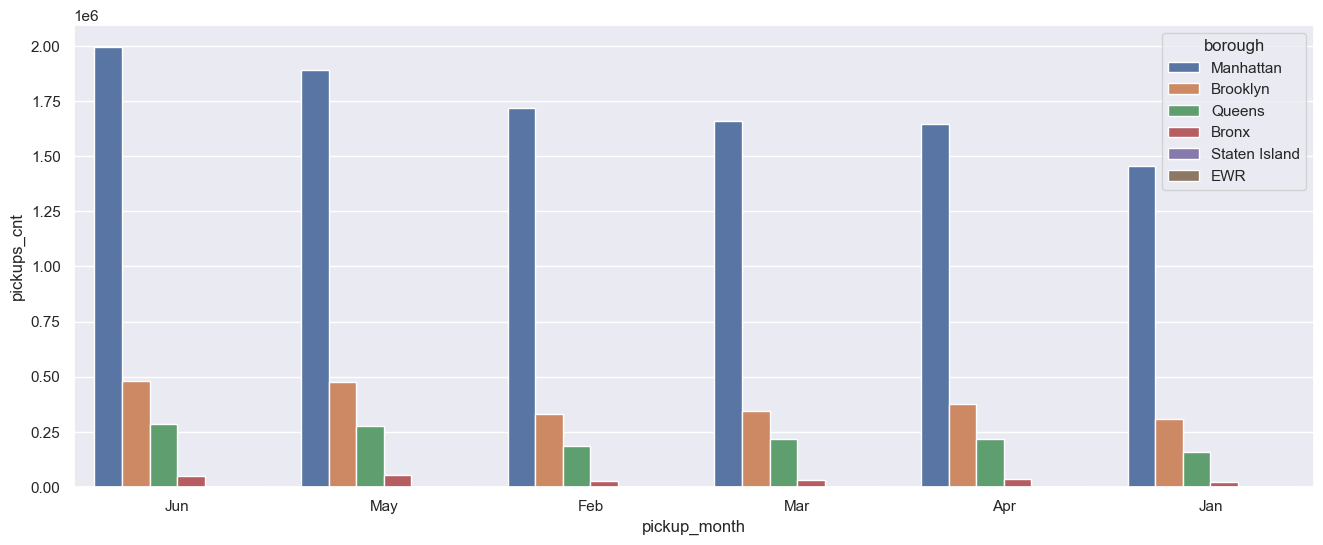

In [54]:
# Визуализируем 
sns.barplot(x='pickup_month', y='pickups_cnt', hue='borough', data=sqldf(q_month))

<Axes: xlabel='pickup_dt', ylabel='pickups'>

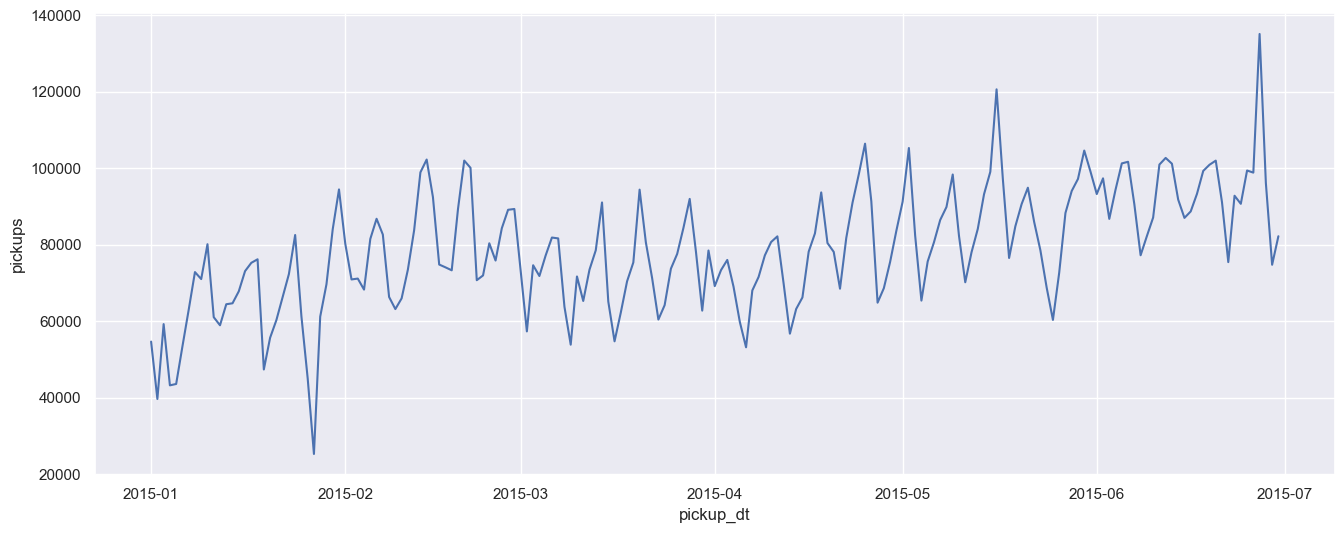

In [130]:
# Визуализируем число поездок по дням
df['pickup_dt'] = pd.to_datetime(df['pickup_dt'])
df_plot = df.set_index('pickup_dt', drop=False)
df_plot = df_plot.resample('D').pickups.sum().to_frame()
sns.lineplot(x='pickup_dt', y='pickups', data=df_plot)

In [170]:
# Посчитаем скользящее среднее с окном 5
q_moving_avg = """SELECT pickup_day,
                         sum_pickups,
                         CAST(AVG(sum_pickups) OVER (ORDER BY sum_pickups ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING) AS INTEGER) AS moving_avg
                  FROM (SELECT pickup_day,
                               SUM(pickups) AS sum_pickups   
                        FROM (SELECT pickups,
                                     DATE(pickup_dt) AS pickup_day
                              FROM df)
                        GROUP BY pickup_day)
                  ORDER BY pickup_day
               """

In [171]:
sqldf(q_moving_avg)

,pickup_day,sum_pickups,moving_avg
0,2015-01-01,54671,54470
1,2015-01-02,39668,37944
2,2015-01-03,59244,59130
3,2015-01-04,43230,39371
4,2015-01-05,43591,43790
...,...,...,...
176,2015-06-26,98856,98722
177,2015-06-27,135111,120721
178,2015-06-28,96150,95996
179,2015-06-29,74766,74717


<Axes: xlabel='pickup_day', ylabel='moving_avg'>

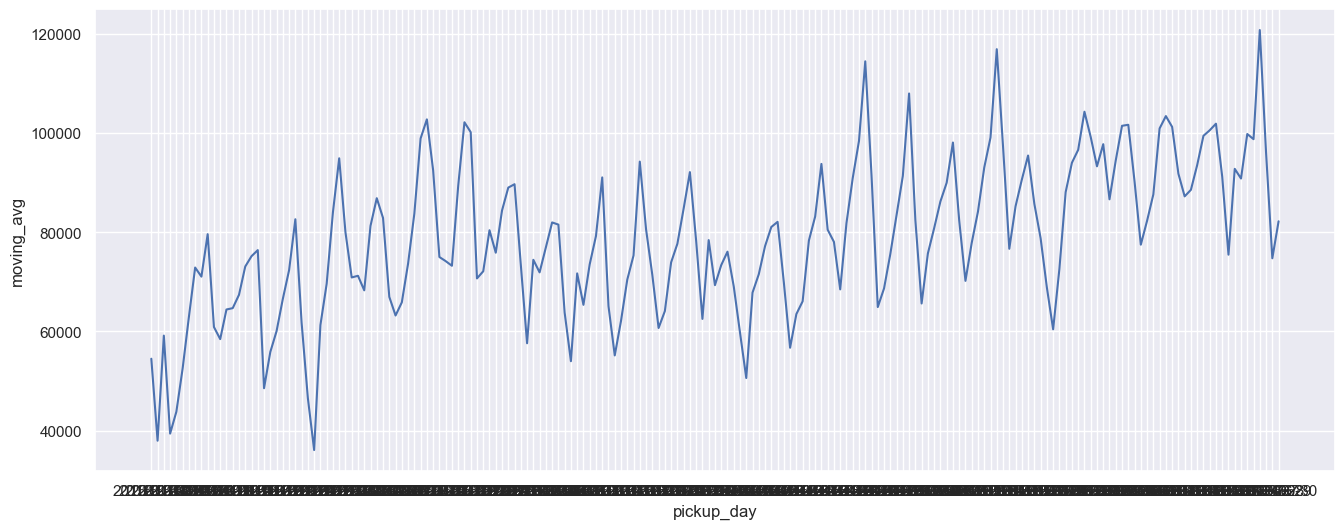

In [182]:
# Визуализируем
sns.lineplot(data=sqldf(q_moving_avg), x='pickup_day', y='moving_avg')

In [377]:
# Чтобы определить выбросы будем использовать межквартильный размах

In [392]:
q_iqr = """WITH df_day AS (SELECT pickups, 
                                 ROW_NUMBER() OVER (ORDER BY pickups) AS row_num,
                                 COUNT(*) OVER() AS total_rows
                           FROM (SELECT pickup_day,
                                        SUM(pickups) AS pickups   
                           FROM (SELECT pickups,
                                        DATE(pickup_dt) AS pickup_day
                                 FROM df)
                           GROUP BY pickup_day))  
            SELECT pickup_day,
                   sum_pickups    
            FROM
            (SELECT pickup_day,
                    sum_pickups,
                    percentile_25,
                    percentile_75,
                   (percentile_75 - percentile_25) * 1.5 AS iqr_max
            FROM (SELECT pickup_day,
                         SUM(pickups) AS sum_pickups,
           (SELECT AVG(pickups)
            FROM df_day
            WHERE row_num IN  
                        (CASE WHEN total_rows % 4 = 0 THEN total_rows / 4 ELSE (total_rows / 4.0) + 0.75 END,
                        ((total_rows / 4.0) - 0.25))) AS percentile_25,
            (SELECT AVG(pickups)
            FROM df_day
            WHERE row_num IN  
                        (CASE WHEN total_rows % 4 = 0 THEN ((total_rows * 3.0) / 4.0) ELSE ((total_rows * 3.0) / 4.0) + 0.25 END,
                        (((total_rows *3.0)/ 4.0) - 0.75))) AS percentile_75                     
            FROM (SELECT pickups,
                         DATE(pickup_dt) AS pickup_day
                  FROM df)
            GROUP BY pickup_day 
            ORDER BY pickup_day))
            WHERE sum_pickups > percentile_75 + iqr_max OR sum_pickups < percentile_25 - iqr_max
      """

In [393]:
# В данных присутствуют два выброса.
# Минимальное количество поездок 27.01.2015г.
# Максимальное количество поездок 27.06.2015г.
sqldf(q_iqr)

,pickup_day,sum_pickups
0,2015-01-27,25288
1,2015-06-27,135111


Выводы:
1. В анализе использовались данные о поездках (с января по июнь 2015 г.) на такси в Нью-Йорке по 6 районам (+1 определён как None). 
2. Наибольшее количество поездок за весь период совершено из района Манхэттен, наименьшее из Международного аэропорта Ньюарк Либерти (EWR).
3. Среднее количество поездок составило 490, медианное 54.
4. Для каждого района проанализировано число поездок по месяцам. Максимальное количество поездок было совершено из района Манхэттен в июне, минимальное в апреле из района Международного аэропорта Ньюарк Либерти (EWR).
5. Из районов Queens и EWR по праздникам в среднем поступило больше заказов, чем в обычные дни. 
6. В данных обнаружено два аномальных значения (минимум 27.01.2015 и максимум 27.06.2015).